# **1. Install packages**

In [ ]:
%%capture
!pip install torchmetrics
!pip install torchinfo

# **2. Import libraries**

In [ ]:
# Data Handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.classification import MulticlassAccuracy
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b0

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

# random
import random

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# typing
from typing import Dict, List

# Warnings
import warnings
warnings.filterwarnings("ignore")

# **3. Load data and Preprocessing**

In [ ]:
# We find the classes we have.
classes = os.listdir("/kaggle/input/cactus/dataset-kaktus")
classes = sorted(classes)
classes

FileNotFoundError: [Errno 2] No such file or directory: 'data.pkl'

In [ ]:
# We create a list where the image paths are located.
IMAGES_PATH = Path("/kaggle/input/cactus/dataset-kaktus")
IMAGES_PATH

PosixPath('/kaggle/input/cactus/dataset-kaktus')

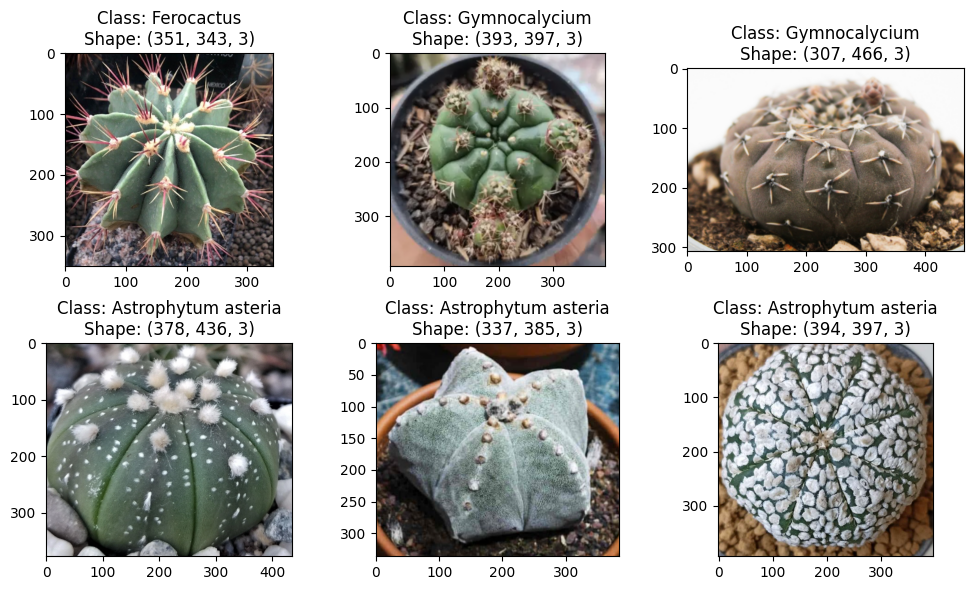

In [ ]:
# We view 6 images chosen at random.
IMAGES_PATH_LIST = list(IMAGES_PATH.glob("*/*.png"))

images_random_selected = random.choices(IMAGES_PATH_LIST, k = 6)

fig,ax = plt.subplots(nrows = 2, ncols = 3, figsize = (10,6))
ax = ax.flat

for i,img in enumerate(images_random_selected):
    img_BGR = cv2.imread(str(img))
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img_RGB)
    ax[i].set_title(f'Class: {img.parent.stem}\nShape: {img_RGB.shape}')

fig.tight_layout()
fig.show()

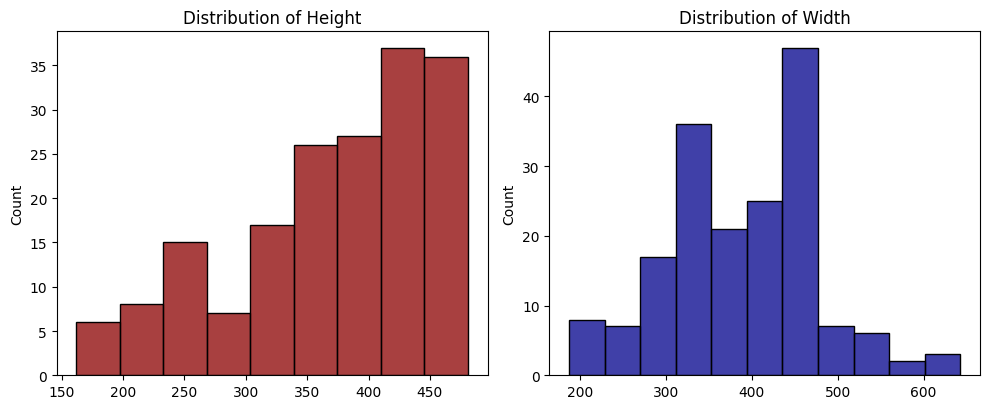

In [ ]:
# We visualize the distribution of the width and height of the images.
seq_height = [None]*len(IMAGES_PATH_LIST)
seq_width = [None]*len(IMAGES_PATH_LIST)

for i,j in enumerate(IMAGES_PATH_LIST):
    img = cv2.imread(str(j))
    seq_height[i] = img.shape[0]
    seq_width[i] = img.shape[1]


# Plots
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4.2))
ax = ax.flat

sns.histplot(seq_height, color = 'darkred', ax = ax[0])
ax[0].set_title('Distribution of Height')

sns.histplot(seq_width, color = 'darkblue', ax = ax[1])
ax[1].set_title('Distribution of Width')

fig.tight_layout()
fig.show()

In [ ]:
# We display the largest width and length.
print(f'Max Height = {max(seq_height)}')
print(f'Max Width = {max(seq_width)}')

Max Height = 481
Max Width = 643


# **4. Preprocessing**

In [ ]:
# We create a pd.DataFrame to store the path of each image and its respective tag to which it belongs.
images_path = [None]*len(IMAGES_PATH_LIST)
labels = [None]*len(IMAGES_PATH_LIST)

for i,img_pth in enumerate(IMAGES_PATH_LIST):
    images_path[i] = img_pth
    labels[i] = img_pth.parent.stem

df_path_and_labels = pd.DataFrame({'img_path':images_path, 'label':labels})
df_path_and_labels.head()

,img_path,label
0,/kaggle/input/cactus/dataset-kaktus/Gymnocalyc...,Gymnocalycium
1,/kaggle/input/cactus/dataset-kaktus/Gymnocalyc...,Gymnocalycium
2,/kaggle/input/cactus/dataset-kaktus/Gymnocalyc...,Gymnocalycium
3,/kaggle/input/cactus/dataset-kaktus/Gymnocalyc...,Gymnocalycium
4,/kaggle/input/cactus/dataset-kaktus/Gymnocalyc...,Gymnocalycium


In [ ]:
# We do a count of each class we have.
df_path_and_labels['label'].value_counts()

label
Ferocactus             60
Astrophytum asteria    60
Gymnocalycium          59
Name: count, dtype: int64

In [ ]:
# Let's separate our paths from each image and its respective label.
X = df_path_and_labels.drop('label', axis = 1)
y = df_path_and_labels['label']

# We divide into training and test set.
# We define the random seed for reproducibility.
SEED = 42

X_train, X_test, y_train, y_test = tts(X,
                                       y,
                                       test_size = 0.3,
                                       random_state = SEED,
                                       stratify = y)

In [ ]:
# We convert our variable containing the labels to number using a mapping, where:
# 0: Astrophytum
# 1: Ferocactus
# 2: Gymnocalycium

label_map = {classes[0]:0, classes[1]:1, classes[2]:2}

y_train_array = np.array(y_train.map(label_map))
y_train_torch = torch.from_numpy(y_train_array)

y_test_array = np.array(y_test.map(label_map))
y_test_torch = torch.from_numpy(y_test_array)

In [ ]:
# We are going to use the transformations that were used on the images that were used to train the model.
weights = ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# We apply the transformations to our images.
images_train = [None] * len(X_train)

for i,(_,img_path_train) in enumerate(X_train.iterrows()):
    img_train = Image.open(img_path_train[0]).convert('RGB')
    images_train[i] = auto_transforms(img_train)

images_test = [None] * len(X_test)

for i,(_,img_path_test) in enumerate(X_test.iterrows()):
    img_test = Image.open(img_path_test[0]).convert('RGB')
    images_test[i] = auto_transforms(img_test)

In [ ]:
# Now we turn everything into a tensor.
X_train_torch = torch.stack(images_train)
X_test_torch = torch.stack(images_test)

In [ ]:
# We create a Dataset class to generate our Dataset's.
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx]
        return x,y

In [ ]:
# We convert to Dataset.
train_dataset = CustomDataset(X_train_torch, y_train_torch)
test_dataset = CustomDataset(X_test_torch, y_test_torch)

In [ ]:
# Now we have to convert our Dataset's to DataLoader's.
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)


In [ ]:
# Let's visualize a batch
images_batch, labels_batch = next(iter(train_dataloader))

images_batch.shape, labels_batch.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

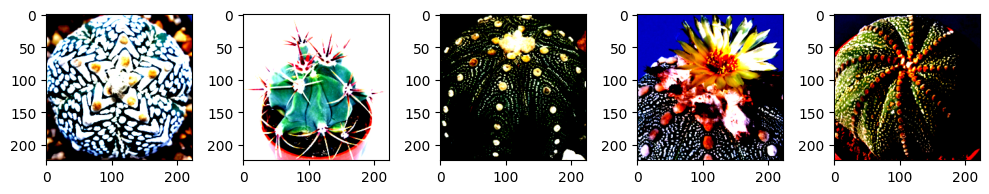

In [ ]:
# Let's see some images after the transformation.
fig,ax = plt.subplots(nrows = 1, ncols = 5, figsize = (10,4.2))
ax = ax.flat

for i in range(0,5):
    ax[i].imshow(X_train_torch[i].permute(1,2,0).numpy())

fig.tight_layout()
fig.show()

# **5. Model: Resnet50**

In [ ]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# We define our Resnet50 model.
model = resnet50(weights = weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


In [8]:
import torch
from torchvision import models
import torch.nn as nn




In [9]:
# Let's visualize the architecture of our model.
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 17,
        row_settings = ['var_names'])


Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [1, 3, 224, 224]  [1, 1000]         --                True
├─Conv2d (conv1)                         [1, 3, 224, 224]  [1, 64, 112, 112] 9,408             True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112] [1, 64, 112, 112] 128               True
├─ReLU (relu)                            [1, 64, 112, 112] [1, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112] [1, 64, 56, 56]   --                --
├─Sequential (layer1)                    [1, 64, 56, 56]   [1, 256, 56, 56]  --                True
│    └─Bottleneck (0)                    [1, 64, 56, 56]   [1, 256, 56, 56]  --                True
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]   [1, 64, 56, 56]   4,096             True
│    │    └─BatchNorm2d (bn1)            [1, 64, 56, 56]   [1, 64, 56, 56]   128               True

In [10]:
# Now let's freeze the parameters of the extractor layers.
for param in model.parameters():
    param.requires_grad = False

In [11]:
# Now let's see how our model turned out.
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 17,
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [1, 3, 224, 224]  [1, 1000]         --                False
├─Conv2d (conv1)                         [1, 3, 224, 224]  [1, 64, 112, 112] (9,408)           False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112] [1, 64, 112, 112] (128)             False
├─ReLU (relu)                            [1, 64, 112, 112] [1, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112] [1, 64, 56, 56]   --                --
├─Sequential (layer1)                    [1, 64, 56, 56]   [1, 256, 56, 56]  --                False
│    └─Bottleneck (0)                    [1, 64, 56, 56]   [1, 256, 56, 56]  --                False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]   [1, 64, 56, 56]   (4,096)           False
│    │    └─BatchNorm2d (bn1)            [1, 64, 56, 56]   [1, 64, 56, 56]   (128)           

We see that the parameters were frozen.

In [12]:
# We visualize the last layer, which we are going to modify.
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [67]:
# We modify the last layer
import os

# Define the correct dataset path (adjust this to the actual dataset path)
dataset_path = "/kaggle/input/cactus/dataset-kaktus"

# Check if the dataset path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The dataset path '{dataset_path}' does not exist.")

# List the directories (each directory represents a class)
classes = os.listdir(dataset_path)

# Sort the class names (if needed)
classes = sorted(classes)

# Now you can safely use 'classes' to modify the final layer of the model
output_shape = len(classes)

model.fc = nn.Linear(in_features = 2048,
                     out_features = output_shape,
                     bias = True)

FileNotFoundError: The dataset path '/kaggle/input/cactus/dataset-kaktus' does not exist.

In [ ]:
# We modify the last layer
output_shape = len(classes)

model.fc = nn.Linear(in_features = 2048,
                     out_features = output_shape,
                     bias = True)

In [17]:
# Once again we visualize our model to see how it turned out with this last modification.
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 17,
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [1, 3, 224, 224]  [1, 1000]         --                False
├─Conv2d (conv1)                         [1, 3, 224, 224]  [1, 64, 112, 112] (9,408)           False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112] [1, 64, 112, 112] (128)             False
├─ReLU (relu)                            [1, 64, 112, 112] [1, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112] [1, 64, 56, 56]   --                --
├─Sequential (layer1)                    [1, 64, 56, 56]   [1, 256, 56, 56]  --                False
│    └─Bottleneck (0)                    [1, 64, 56, 56]   [1, 256, 56, 56]  --                False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]   [1, 64, 56, 56]   (4,096)           False
│    │    └─BatchNorm2d (bn1)            [1, 64, 56, 56]   [1, 64, 56, 56]   (128)           

In [18]:
# Now we have to define our loss function and optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01, weight_decay = 0.1)

- **Functions that will be used to execute the training.**

In [19]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    accuracy_train = MulticlassAccuracy(num_classes = len(classes), average = 'micro').to(device)

    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = model(X)

        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_probs = torch.softmax(y_pred_logit, dim = 1)
        accuracy_train.update(y_pred_probs, y)

    train_loss = train_loss/len(dataloader)
    train_accuracy = accuracy_train.compute()

    return train_loss, train_accuracy


In [20]:
# We define our checkpoint.
def save_checkpoint(filename, epoch, model, loss, optimizer):
    state = {"filename":filename,
             "epoch":epoch,
             "model":model.state_dict(),
             "loss":loss,
             "optimizer":optimizer.state_dict()}

    torch.save(state, filename)

In [59]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module):

    model.eval()

    test_loss = 0.

    accuracy_test = MulticlassAccuracy(num_classes = len(classes), average = 'micro').to(device)

    with torch.inference_mode():

        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)

            loss = loss_fn(y_pred_logit, y)
            test_loss += loss.item()

            y_pred_probs = torch.softmax(y_pred_logit, dim = 1)
            accuracy_test.update(y_pred_probs, y)

    test_loss = test_loss/len(dataloader)
    test_accuracy = accuracy_test.compute()

    return test_loss, test_accuracy


In [60]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int):

    results = {"train_loss":[],
               "test_loss":[],
               "train_accuracy":[],
               "test_accuracy":[]}

    best_test_loss = float('inf')

    for epoch in tqdm(range(epochs)):

        train_loss, train_accuracy = train_step(model = model,
                                                dataloader = train_dataloader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer)

        test_loss, test_accuracy = test_step(model = model,
                                             dataloader = test_dataloader,
                                             loss_fn = loss_fn)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            file_name = "best_model.pt"
            save_checkpoint(file_name, epoch, model, best_test_loss, optimizer)


        print(f"Epoch: {epoch + 1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Test Loss: {test_loss:.4f} | ",
              f"Test Accuracy: {test_accuracy:.4f}")

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)

    return results


In [61]:
# Define the seed for reproducibility
SEED = 42  # You can choose any integer value as the seed

# Set the seed for reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups (if applicable)
np.random.seed(SEED)  # For NumPy (if you're using NumPy)
random.seed(SEED)  # For Python's random module

# If you're using pandas or other libraries that depend on randomness, you might need to set their seeds as well

# Now you can proceed with the training
EPOCHS = 100



In [62]:
# Set the random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED) # Fixed: Changed 'torch.cuda.manu' to 'torch.cuda.manual_seed(SEED)'


# ... rest of your code ...

In [75]:
# We execute the training.
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

EPOCHS = 100

MODEL_RESULTS = train(model.to(device), train_dataloader, test_dataloader, loss_fn, optimizer, EPOCHS)

NameError: name 'train_dataloader' is not defined

In [41]:
# Function to plot the loss and metric during each training epoch.
def plot_loss_metric_curve(model_results:Dict[str,List[float]]):

    train_loss = model_results["train_loss"]
    test_loss = model_results["test_loss"]

    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    test_accuracy = [float(value) for value in model_results["test_accuracy"]]

    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    plt.style.use("ggplot")
    axes = axes.flat

    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(test_loss, color = "blue", label = "Test")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()

    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(test_accuracy, color = "blue", label = "Test")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()

    fig.tight_layout()
    fig.show()

In [76]:
plot_loss_metric_curve(MODEL_RESULTS)

NameError: name 'MODEL_RESULTS' is not defined

In [71]:
# We load the best model.
checkpoint_path = "best_model.pt"
checkpoint = torch.load(checkpoint_path)

FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pt'

**Predictions**

In [ ]:
model.load_state_dict(checkpoint["model"])

model.eval()
with torch.inference_mode():
    y_pred_logits_train = model(X_train_torch.to(device))
    y_pred_logits_test = model(X_test_torch.to(device))

In [ ]:
y_pred_prob_train = torch.softmax(y_pred_logits_train, dim = 1).cpu()
y_pred_class_train = torch.argmax(y_pred_prob_train, dim = 1).numpy()

y_pred_prob_test = torch.softmax(y_pred_logits_test, dim = 1).cpu()
y_pred_class_test = torch.argmax(y_pred_prob_test, dim = 1).numpy()

**Confusion Matrix**

In [ ]:
cf_mx_train = confusion_matrix(y_train_array, y_pred_class_train)
cf_mx_test = confusion_matrix(y_test_array, y_pred_class_test)

NameError: name 'cf_mx_train' is not defined

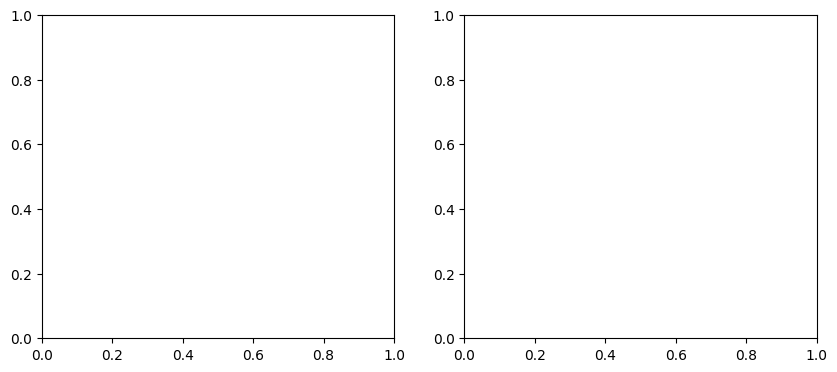

In [49]:
# Confusion Matrix Plot
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4.2))
ax = ax.flat
sns.heatmap(cf_mx_train,
            cmap = 'Blues',
            annot = True,
            fmt = ' ',
            annot_kws = {"fontsize":10,
                         "fontweight":"bold"},
            linewidths = 1,
            linecolor = "white",
            cbar = False,
            square = True,
            xticklabels = classes,
            yticklabels = classes,
            ax = ax[0])
ax[0].set_title('Confusion Matrix Train', fontsize = 12, fontweight = 'bold', color = 'black')

sns.heatmap(cf_mx_test,
            cmap = 'Reds',
            annot = True,
            fmt = ' ',
            annot_kws = {"fontsize":10,
                         "fontweight":"bold"},
            linewidths = 1,
            linecolor = "white",
            cbar = False,
            square = True,
            xticklabels = classes,
            yticklabels = classes,
            ax = ax[1])
ax[1].set_title('Confusion Matrix Test', fontsize = 12, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

**Classification Report**

In [48]:
print("=="*30)
print(" " * 13, "Classification Report Train")
print("=="*30)
print(classification_report(y_train_array, y_pred_class_train))

print("=="*30)
print(" " * 13, "Classification Report Test")
print("=="*30)
print(classification_report(y_test_array, y_pred_class_test))

              Classification Report Train


NameError: name 'y_train_array' is not defined